In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
# %matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


failed: sc.T_STEP = (1.0*((1.0*T_MAX)/NUM_STEPS))
(1, 512, 1000)
Max N (deg):  0.0876364961223
Max S (deg):  0.0186312906872


<IPython.core.display.Javascript object>


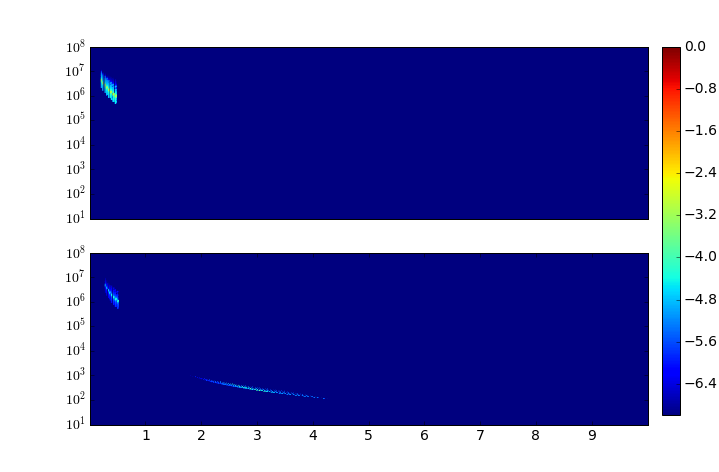

-2.81543762711
-7.0
0.000325177366389
2382


In [4]:
import re
from load_sim_constants import load_sim_constants

# ------------------------------------------------
# Loads all pN, pS files in a directory, sorted by frequency
# returns: pN, pS (nFreqs x nTimes x nEnergies numpy arrays)
# ------------------------------------------------
def load_pfiles(directory, L):
    # Get files, frequencies:
    d = os.listdir(directory)


    freqs_pN = []
    freqs_pS = []
    l_pN = []
    l_pS = []

    p = re.compile("\d+")
    for s in d:
        if s.endswith(".dat"):
            if s.startswith('pN'):
                tmp = p.findall(s)
                freqs_pN.append(int(tmp[0]))
                l_pN.append(float(tmp[1]))

            elif s.startswith('pS'):
                tmp = p.findall(s)
                freqs_pS.append(int(tmp[0]))
                l_pS.append(float(tmp[1]))

    freqs_pN.sort()
    freqs_pS.sort()

    # print l_pN
    assert freqs_pN == freqs_pS, "frequency mismatch!"

    freqs = freqs_pN

    #Pre-allocate
    pN = np.zeros((len(freqs), sc.NUM_E, sc.NUM_STEPS))
    pS = np.zeros((len(freqs), sc.NUM_E, sc.NUM_STEPS))


    # Binary files -- little endian, four-byte floats
    dt = np.dtype('<f4')

    # for f, l in zip(freqs, l_pN):
    for f_ind, f in enumerate(freqs):
        # for binary-formatted files
#         print f
#         print L
#         print os.path.join(directory,'pN%d_%g.dat'%(f,L))
        tmp_N = np.fromfile(os.path.join(directory,'pN%d_%g.dat'%(f,L)),dtype=np.dtype('<f4'))
        pN[f_ind, :,:] = tmp_N.reshape(sc.NUM_E, sc.NUM_STEPS, order='c')
        tmp_S = np.fromfile(os.path.join(directory,'pS%d_%g.dat'%(f,L)),dtype=np.dtype('<f4'))
        pS[f_ind, :,:] = tmp_S.reshape(sc.NUM_E, sc.NUM_STEPS, order='c')
        
        # For ASCII-formatted files
#         pN.append(np.loadtxt(os.path.join(directory,"pN%d_%d.dat"%(f,L))))
#         pS.append(np.loadtxt(os.path.join(directory,"pS%d_%d.dat"%(f,L))))
        
    #print np.shape(pN)
    #print np.shape(pS)
    return pN, pS


sc = load_sim_constants('codesrc/consts.h')
L = 2.422
directory = '/shared/users/asousa/WIPP/WIPPv4/outputs/pwr_-100000/in_45/out_2.422/' 

pN, pS = load_pfiles(directory, L)

print np.shape(pN)
print "Max N (deg): ", np.max(180./np.pi*np.sqrt(pN))
print "Max S (deg): ", np.max(180./np.pi*np.sqrt(pS))
plot_pN_pS(np.sqrt(np.sum(pN, axis=0)), np.sqrt(np.sum(pS, axis=0)), sc)

In [3]:
# from calc_scattering import calc_scattering
# import sim_consts as sc
import time
from matplotlib.colors import LogNorm

# ----------------------------------------------------------------------------
# Plot a single time-energy deflection matrix
# ----------------------------------------------------------------------------

def plot_pN_pS(pN, pS, sc):
#     pN_file=os.path.join(directory, 'pN%g_%g.dat'%(f,L))
#     pS_file=os.path.join(directory, 'pS%g_%g.dat'%(f,L))

#     # This version for text files
#     pN = np.loadtxt(pN_file)
#     pS = np.loadtxt(pS_file)
#     #pN = np.flipud(pN)
#     #pS = np.flipud(pS)

    tvec = np.linspace(sc.T_STEP,sc.T_MAX,sc.NUM_STEPS)

    clims = [-7, 0]


    pN_P = np.log10(pN)
    np.clip(pN_P,clims[0],clims[1],out=pN_P)

    pS_P = np.log10(pS)
    np.clip(pS_P,clims[0],clims[1],out=pS_P)

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # The goods
    p1 = ax1.imshow(pN_P,origin='lower',aspect='auto')
    p1.set_clim(clims)
    p2 = ax2.imshow(pS_P,origin='lower',aspect='auto')
    p2.set_clim(clims)

    # Colorbar
#    cax = fig.add_axes([0.77, 0.12, 0.025, 0.78])
    cax = fig.add_axes([0.92, 0.12, 0.025, 0.78])
    fig.colorbar(p1,cax=cax)

    # Label axes
    
    tlabels = np.arange(1,np.floor(sc.T_MAX))
    tinds =  [np.argmax(tt <= tvec) for tt in tlabels]
    ax2.set_xticks(tinds)
    tlabel_strings = ['%d'%k for k in tlabels]
    ax2.set_xticklabels(tlabel_strings)
    

    ax1.get_xaxis().set_visible(False)
#     ax2.set_xticks(np.floor(np.linspace(0,sc.NUM_STEPS-1,sc.T_MAX + 1)))
#     ax2.set_xticklabels(np.floor(tvec[ax2.get_xticks().astype(int)]))

    # Label each power of 10
    logvals = np.arange(np.log10(sc.E_MIN), np.log10(sc.E_MAX)+1)
    einds =  [np.argmax(lv <= np.log10(sc.E_tot_arr)) for lv in logvals]
    einds[-1] = sc.NUM_E - 1 

    ylabel_strings = ['$10^%d$'%k for k in logvals]
    ax1.set_yticks(einds)
    ax1.set_yticklabels(ylabel_strings)
    ax2.set_yticks(einds)
    ax2.set_yticklabels(ylabel_strings)

#     fig.subplots_adjust(hspace=0.03, wspace=0.05)
    fig.canvas.draw()
    plt.show()

    print np.max(pN_P)
    print np.min(pN_P)
    print np.max(pS)
    print sum(sum((pN!=0)))

# plot_pN_pS(np.sqrt(np.sum(pN, axis=0)), np.sqrt(np.sum(pS, axis=0)), sc)

In [35]:
L = 3
directory = '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPy/python/c/out_binfiles/' 

pN, pS = load_pfiles(directory, L)

print np.shape(pN)

plot_pN_pS(np.sqrt(np.sum(pN, axis=0)), np.sqrt(np.sum(pS, axis=0)), sc)

IOError: [Errno 2] No such file or directory: '/Users/austin/FUSE/shared/users/asousa/WIPP/WIPPy/python/c/out_binfiles/pN0_3.dat'

In [ ]:
np.shape(pN)

plot_pN_pS(np.sum(pN, axis=0), np.sum(pS, axis=0), sc)

In [ ]:
import sim_consts as sc
from matplotlib.colors import LogNorm


pN_sum = np.sqrt(np.sum(pN, axis=0))
pS_sum = np.sqrt(np.sum(pS, axis=0))


clims = [0.1,2]
tvec = np.linspace(0,sc.T_MAX,sc.NUM_STEPS)

plt.figure()
# plt.imshow(pS_sum)
# plt.subplot(211)
# plt.imshow(pN_sum)
plt.pcolor(tvec, sc.E_tot_arr*1e-6, pS_sum,  norm=LogNorm(vmin=clims[0], vmax=clims[1]))
plt.clim(clims)
plt.colorbar()
# plt.subplot(212)
#plt.imshow(pS_sum)
# plt.pcolor(tvec, sc.E_tot_arr, pS_sum)


print np.max(pN_sum)
print np.max(pS_sum)
print sum(sum(sum(np.isnan(pN))))
print sum(sum(sum(np.isnan(pS))))





In [ ]:
print sc.E_MIN
print sc.E_MAX

print np.log10(sc.E_MAX)
print np.log10(sc.E_MIN)

logvals = np.arange(np.log10(sc.E_MIN), np.log10(sc.E_MAX)+1)

#inds = find(sc.E_tot_arr > logvals)

#einds = [np.where(lv > np.log10(sc.E_tot_arr))[0][-1] for lv in logvals]
einds =  [np.argmax(lv <= np.log10(sc.E_tot_arr)) for lv in logvals]
einds[-1] = sc.NUM_E - 1 

print einds

In [ ]:
np.arange(0,100,step=0.5)

33
